<a href="https://colab.research.google.com/github/RLWH/reinforcement-learning-notebook/blob/master/4.%20Model%20Free%20Control/Algorithm_implementation_Blackjack_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation for the algorithms

Solving the Blackjack, Windy Gridworld by

1. Monte Carlo Control
2. Off-policy Monte Carlo Control
2. SARSA
3. Q-Learning
4. Expected SARSA

# 1. The Blackjack v0 environment

In [0]:
import random
import numpy as np
import gym
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from gym.envs.toy_text import blackjack
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D

In [0]:
%matplotlib inline
plt.style.use('ggplot')

In [0]:
env = gym.make('Blackjack-v0')

In [0]:
env.reset()

(20, 10, False)

#### Define the sample policy

In [0]:
def sample_policy(observation):
    """
    For a given observation, if score < 20, hit. Elase stick.
    Return action 0 or 1
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

In [0]:
def print_observation(observation):
    """
    Print observation
    """
    score, dealer_score, usable_ace = observation
    print("Player score: %s (Usable Ace: %s), Dealer score: %s"
          % (score, usable_ace, dealer_score))

In [0]:
def generate_episode(policy, env, verbose=False):
    """
    Generate a sequence according to the policy
    """
    
    states, actions, rewards = [], [], []
    
    observation = env.reset()
    while True:
        if verbose:
            print_observation(observation)
        states.append(observation)
        action = policy(observation)
#         print("Action taken: %s" % action)
        actions.append(action)
        observation, reward, done, info = env.step(action)
        rewards.append(reward)
        
        if done:
            if verbose:
                print("Game end. Reward: %s; Observation: %s" % (reward, observation))
            break
            
    return states, actions, rewards

In [0]:
generate_episode(sample_policy, env, True)

Player score: 16 (Usable Ace: False), Dealer score: 8
Player score: 20 (Usable Ace: False), Dealer score: 8
Game end. Reward: 1.0; Observation: (20, 8, False)


([(16, 8, False), (20, 8, False)], [1, 0], [0, 1.0])

#### Plotting functions

In [0]:
def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, 22)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

# 2. Monte Carlo methods - Prediction

For using MC methods, we generate many episodes of the game, and count how many times a particular state is visited.

We use the first-visit MC method here, which means we only count the first visit of each episode. 

In [0]:
def first_visit_mc_prediction(policy, env, num_episodes, gamma=1.0, verbose=False):
    
    # Initialise value function V for all states
    V = defaultdict(float)
    
    # Initialise an empty return list for all states
    returns = defaultdict(float)
    
    # Track number of visits
    N = defaultdict(int)
    
    for i in range(num_episodes):
        # Create an empty list to keep track of the states, actions and rewards
        states, actions, rewards = generate_episode(policy, env)
        
        G = 0
        
        # Reverse the range order, from t-1, t-2, ..., 0
        for t in range(len(states) - 1, -1, -1):
            R = rewards[t]
            S = states[t]
            G = gamma * G + R
            
            # Track only the first visit
            if S not in states[:t]:
                N[S] += 1
                V[S] += (G - V[S]) / N[S]
    
    return V

In [0]:
V = first_visit_mc_prediction(sample_policy, env, 10000)

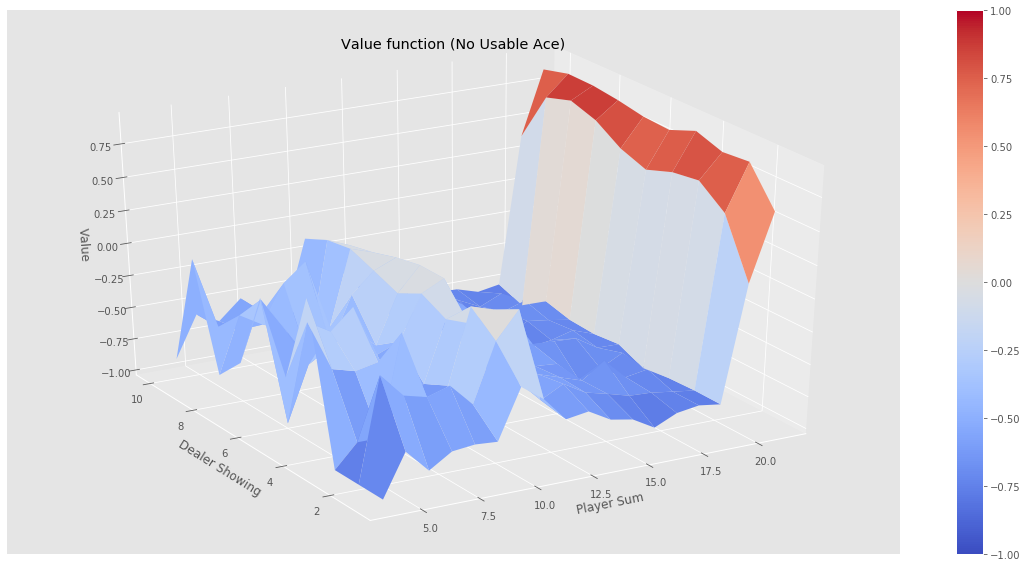

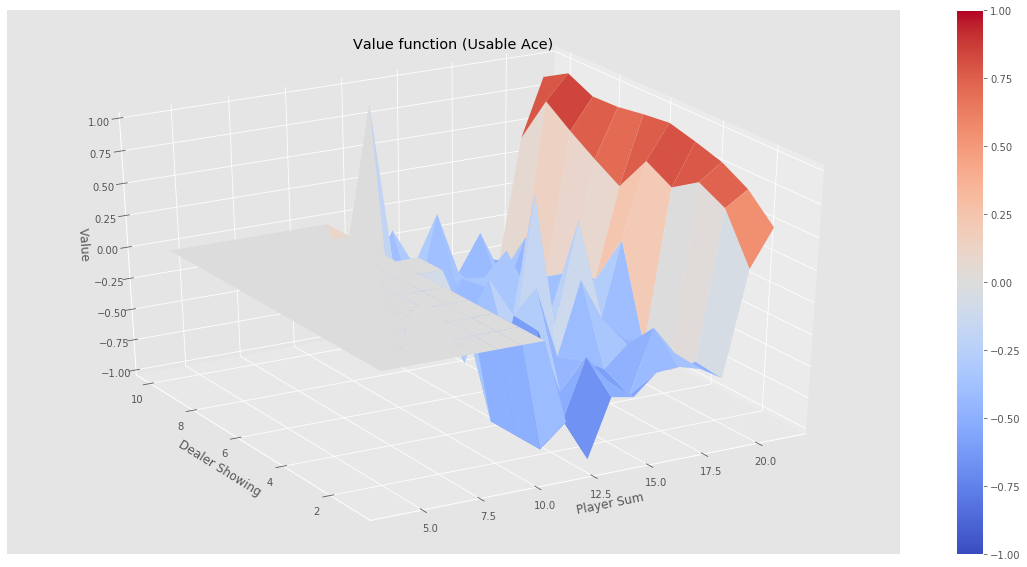

In [0]:
plot_value_function(V, title="Value function")

# 3. Monte Carlo methods - MC-ES Algorithm

For Monte Carlo policy iteration, it alternates between evaluation and improvement on an episode-by-episode basis. After each episode, the observed returns are used for policy evaluation, and the the policy is improved at all the states visited in the episode. 

#### Pseudo Code
---
```
Initialise:
  pi(s) in A(s) for all s in S
  Q(s,a) for all s in S, a in A(s)
  Returns(s,a) - Empty list, for all s in S and a in A(s)

Loop forever (for each episode)
   Choose S0 in S, A0 in A(S0) randomly such that all pairs have porbability > 0
   Generate an episode from S0, A0, following pi: S0, A0, R1, S1, A1, ..., RT
   G = 0
   Loop for each step of episode, t=T-1, T-2, ..., 0
   G = gamma * G + R_t+1
   Unless the pair St, At appears in S0, A0, S1, A1, ..., St-1, At-1:
    Append G to Returns(St, At)
    Q(St, At) = Average(Returns(St, At))
    pi(St) = argmax_a(Q(St, a))
    

```
---

In [0]:
def random_policy(observations, env):
    return env.action_space.sample()

In [0]:
def generate_episode_random(policy, env, verbose=False):
    """
    Generate a sequence according to the policy
    """
    
    states, actions, rewards = [], [], []
    
    observation = env.reset()
    while True:
        if verbose:
            print_observation(observation)
        states.append(observation)
        action = policy(observation, env)
        if verbose:
            print("Action taken: %s" % action)
        actions.append(action)
        observation, reward, done, info = env.step(action)
        rewards.append(reward)
        
        if done:
            
            if verbose:
                print("Game end. End state: %s; Reward: %s" % (observation, reward))
            break
            
    return states, actions, rewards

In [0]:
generate_episode_random(random_policy, env, verbose=True)

Player score: 14 (Usable Ace: False), Dealer score: 8
Action taken: 0
Game end. End state: (14, 8, False); Reward: 1.0


([(14, 8, False)], [0], [1.0])

In [0]:
def epsilon_greedy_policy(qs, env, eps=1e-3):
    """
    Epsilon Greedy Policy
    """
    if random.uniform(0, 1) < eps:
        return env.action_space.sample()
    else:
        return np.argmax(qs)

In [0]:
def mc_es_control(env, num_episodes, gamma=1.0, esp=1e-3, verbose=False):
    """
    Monte Carlo Exploratory Start control
    """
    
    # Initialise q function
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
#     returns = defaultdict(float)
    
    # Initialise new policy
    policy = defaultdict(float)
    
    for i in range(1, num_episodes+1):
        # Generate a new episode
        states, actions, rewards = generate_episode_random(random_policy, env)
        G = 0
        for t in range(len(states)):
            R = rewards[t]
            A = actions[t]
            S = states[t]
            G = gamma * G + R
            
            # Track only the first visit
            if (S, A) not in zip(states[:t], actions[:t]):
                N[S][A] += 1
                Q[S][A] += (G - Q[S][A]) / N[S][A]
#                 policy[S] = np.argmax(Q[S])
                policy[S] = epsilon_greedy_policy(Q[S], env, esp=esp)
    
    return Q, policy
    

In [0]:
Q, optim_policy = mc_es_control(env, num_episodes=500000)

In [0]:
optim_policy

defaultdict(float,
            {(4, 1, False): 1,
             (4, 1, True): 0.0,
             (4, 2, False): 1,
             (4, 2, True): 0.0,
             (4, 3, False): 1,
             (4, 3, True): 0.0,
             (4, 4, False): 1,
             (4, 4, True): 0.0,
             (4, 5, False): 1,
             (4, 5, True): 0.0,
             (4, 6, False): 0,
             (4, 6, True): 0.0,
             (4, 7, False): 1,
             (4, 7, True): 0.0,
             (4, 8, False): 1,
             (4, 8, True): 0.0,
             (4, 9, False): 1,
             (4, 9, True): 0.0,
             (4, 10, False): 1,
             (4, 10, True): 0.0,
             (5, 1, False): 1,
             (5, 1, True): 0.0,
             (5, 2, False): 1,
             (5, 2, True): 0.0,
             (5, 3, False): 1,
             (5, 3, True): 0.0,
             (5, 4, False): 1,
             (5, 4, True): 0.0,
             (5, 5, False): 1,
             (5, 5, True): 0.0,
             (5, 6, False): 1,
   

In [0]:
def plot_policy(Q, policy):
    min_x = min(k[0] for k in Q.keys())
    max_x = max(k[0] for k in Q.keys())
    min_y = min(k[1] for k in Q.keys())
    max_y = max(k[1] for k in Q.keys())

    # x-range is dealers card score
    x_range = np.arange(min_x, max_x + 1)
    
    # y-range is players card score
    y_range = np.arange(min_y, max_y + 1)
    
    # Create meshgrid
    X, Y = np.meshgrid(x_range, y_range)
    
    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: policy[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: policy[(_[0], _[1], True)], 2, np.dstack([X, Y]))
    
    print(Z_ace)
    print(Z_noace)
    
    fig = plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(121)
    sns.heatmap(ax=ax1, data=Z_ace, xticklabels=x_range, yticklabels=y_range)
#     ax1.set(xlim=(min_x, max_x), ylim=(min_y, max_y))
    
    ax2 = fig.add_subplot(122)
    sns.heatmap(ax=ax2, data=Z_noace, xticklabels=x_range, yticklabels=y_range)
#     ax2.set(xlim=(min_x, max_x), ylim=(min_y, max_y))

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]]
[[1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]]


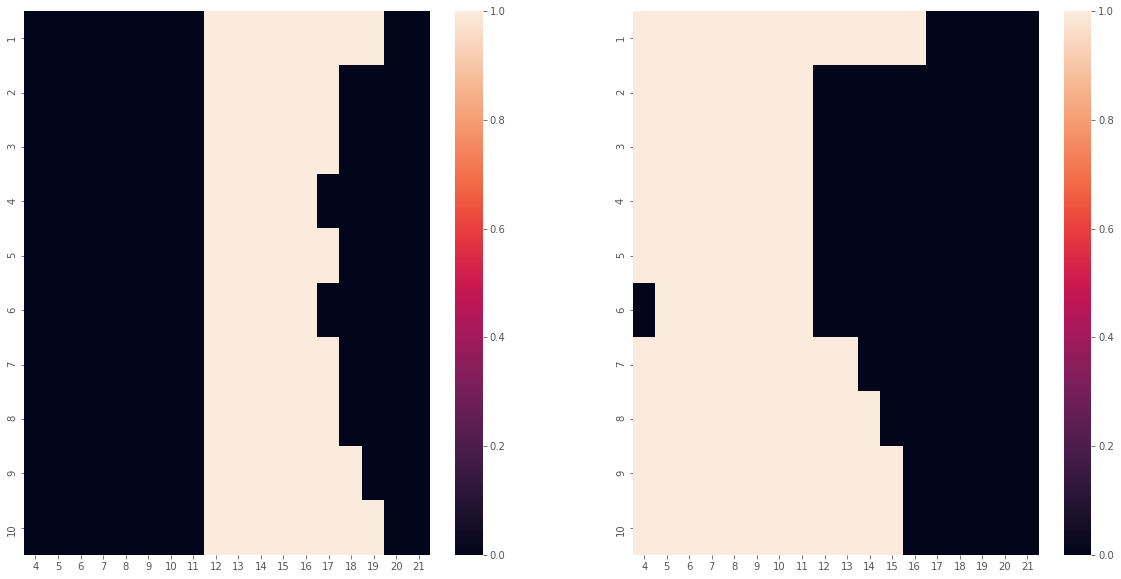

In [0]:
plot_policy(Q, optim_policy)

# 4. Off-policy Monte Carlo Prediction

### Applying to Monte Carlo value estimation
Recall from Monte Carlo value estimation:

If we wish to estimate a value of state $s$ under policy $\pi$, i.e. $v_{\pi}(s)$, we can generate a set of episode that pass through $s$ and average the returns of the visits to $s$. 

There are two ways of averaging. We can either:
1. Average only the first visits to state $s$, which is called the first-visit MC method, or
2. Average all visits to state $s$, which is called every-visit MC method.

The same methodology also applies to off-policy method with a slight tweak.
If we are using the first-visit method, under off-policy estimation, we first denote $J(s)$ as the as the set of all time steps in which state $s$ is visited, or first-visited, and T(t) denote the first time of termination following time t, G_t denite the return after t up to T. Then, to estimate $v_{\pi}(s)$, we simply scale the returns by ratios and averages the result:
\begin{equation}
V(s) = \frac{\sum_{t \in J(s)} \rho_{t:T(t)-1}G_t}{|J(s)|}
\end{equation}

### Incremental update
Suppose we have a sequence of returns $G_1, G_2, ..., G_{n-1}$, all starting in the same state, and each with a corresponding random weight $W_i = \rho_{t_i:T(t_i) - 1}$, then we can form the estimate
\begin{equation}
V_n = \frac{\sum_{k=1}^{n-1}W_kG_k}{\sum_{k=1}^{n-1}W_k}, \hspace{1cm} n \geq 2
\end{equation}

and the update rule becomes
\begin{equation}
V_{n+1} = V_{n} + \frac{W_n}{C_n}[G_n - V_n], \hspace{1cm} n \geq 1
\end{equation}
and

\begin{equation}
C_{n+1} = C_n + W_{n+1}
\end{equation}
where $C_0 = 0$ and $V_1$ is arbitrary.

The update rule is same for Q, just need to replace $V(s)$ by $Q(s,a)$

##### Pseudo code of off-policy MC prediction for Q
---
```
Input: an arbitrary target policy pi
Initialise, for all s in S, a in A(s):
    Q(s,a) arbitarily
    C(s,a) = 0
    
Loop forever for each episode:
    mu = any policy with converge of pi
    Generate an episode following mu: S0, A0, R1, ..., ST-1, AT-1, RT
    
    G = 0
    W = 1
    
    Loop for each step of episode, t = T-1, T-2, ..., 0, while W =/= 0:
        G = gamma * G + Rt+1
        C(s,a) = C(s,a) + W
        Q(s,a) = Q(s,a) + W/C(s,a) * abs(G - Q(s,a))
        W = W * (pi(a|s) / mu(a|s))
```
---

# 5. TD(0) Prediction

### The algorithm of TD(0)

#### Backup diagram (p.121)
- The value estimate for the state node at the top of the backup diagram is updated on the basis of the one sample transition from it to the immediately following state
- i.e. Sample update
- Using the value of the successor and the reward along the way to compute a backed-up value, and then updating the value of the original state (or state-action pair) accordingly.
- Sample updates differ from the expected updates of DP methods in that they are based on a single sample successor rather than on a complete distribution of all possible succssors (as what DP does)

#### TD error
- The quantity $R_{t+1} + \gamma V(S_{t+1}) - V(S_t)$ can be considered as an error term. This is called *TD error*
\begin{equation}
\delta_t := R_{t+1} + \gamma V(S_{t+1}) - V(S_t)
\end{equation}
- We can see that TD error is timestep specific, and it depends on the next state and next reward. 
- THus, TD error is only available at timestep $t+1$

#### Pseudo-code

---
```
Input: the policy pi to be evaluated
Algorithm parameter: stepsize alpha in (0,1]
Initialize V(s) for all s in all states, arbitrarily except that V(terminal) = 0

Loop for each episode:
    Initialise S
    Loop for each step of episode:
        A = action given by pi for S
        Take action A, observe R, S'
        V(S) = V(S) + alpha * [R + gamma * V(S') - V(S)]
        S = S'
    until S is terminal
```
---

TD(0) is a *boostrapping* method, like DP, as its update in part of an existing estimate. We know from Ch3 that 


\begin{equation} 
\begin{split}
v_{\pi}(s) & = E_{\pi}[G_t | S_t = s] \\
& = E_{\pi}[R_{t+1} + \gamma G_{t+1} | S_t = s] \\
& = E_{\pi}[R_{t+1} + \gamma v_{\pi}(S_{t+1}) | S_t = s]
\end{split}
\end{equation}

In [0]:
env.step(0)

((20, 4, True), -1.0, True, {})

In [0]:
def td_prediction(env, policy, num_episodes, gamma=1.0, alpha=0.1):
    """
    TD(0) Prediction
    """
    
    # Initialise V(s) for s in all atates, arbitrarily except that V(T) = 0
    V = defaultdict(float)
    N = defaultdict(float)
    
    for i in range(num_episodes):
        state = env.reset()
    
        while True:
            
            # Select an action given by pi for S
            action = policy(state)
            
            # Take action A, observe R, ns
            next_state, reward, done, info = env.step(action)
            
#             print(next_state, reward, done, info)
            
            # TD update
            N[state] += 1
            V[state] += alpha * ((reward + gamma * V[next_state]) - V[state])
            
            if done:
                break
            
            # Update state
            state = next_state
            
    return V

In [0]:
V = td_prediction(env, sample_policy, 500000, alpha=0.02)

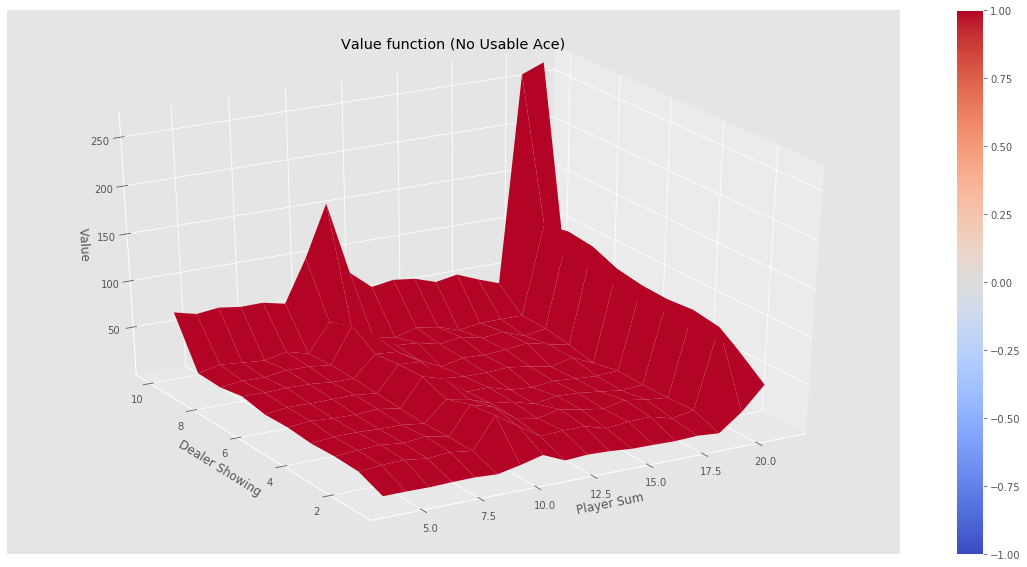

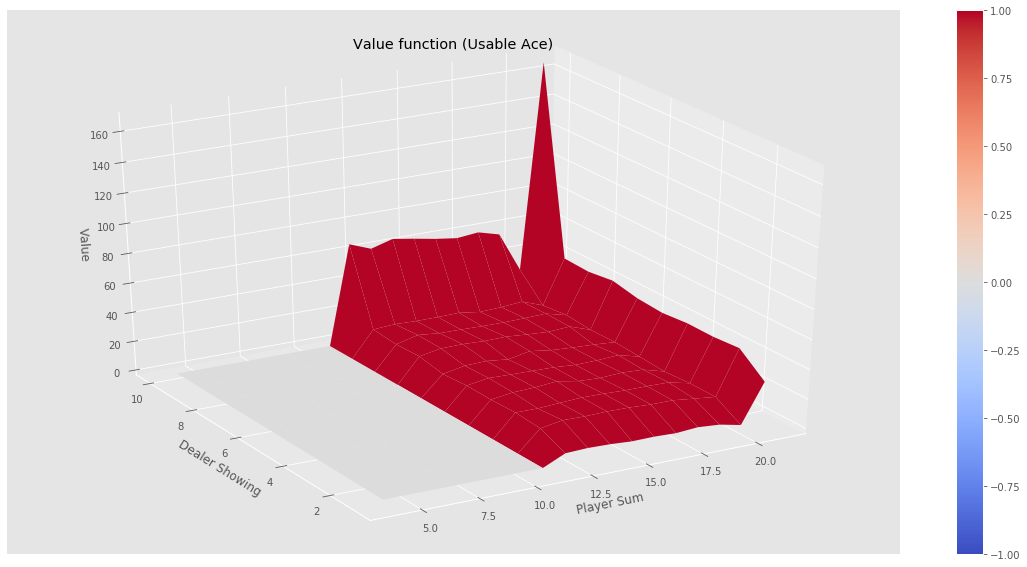

In [0]:
plot_value_function(V, title="Value function")

# 6. SARSA Update

For a transition form a state-action pair to another state-action pair, we can have an update on the Q-value
\begin{equation}
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t)]
\end{equation}

As the TD algorithm is updated after every transition, which consists of the quintuple of events $(S_t, A_t, R_{t+1}, S_{t+1}, A_{t+1})$, this is also known as the SARSA algorithm.

### Plugging in SARSA into the generalised policy iteration (GPI) framework
1. Policy evaluation Sarsa, $Q \approx q_{\pi}$
2. Policy improvement $\epsilon$-greedy policy improvement

### Pseudo code of SARSA
---
```
Initialise Q(s,a) for all s in S, a in A(s), arbitrarily, and Q(T,.)=0
Loop for each episode:
    Initialise S
    Choose A from S using policy derived from Q (e.g. esp-greedy)
    Loop for each step of episode:
        Take action A, observe R, S'
        Choose A' from S' using policy derived from Q (e.g. esp-greedy)
        Q(St,At) = Q(St,At) + alpha * (R + gamma * Q(St+1, At+1) - Q(St, At))
        St = St+1; At = At+1
        Until S is terminal
```
---

In [0]:
def sarsa_update(env, num_episodes, esp=0.05, 
                 alpha=0.01, gamma=1.0, verbose=True):
    """
    SARSA Update implementaiton
    """
    
    # Initialise Q(s,a) for all s in S, a in A(s)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Initialise a esp-greedy policy
    policy = epsilon_greedy_policy
    
    for i in range(num_episodes):
        
        state = env.reset()
        
        while True:
            
            # Select an action given by pi for S
            action = policy(Q[state], env, esp=esp)

            # Take action A, observe R, ns
            next_state, reward, done, info = env.step(action)
            
            # Select next action given by pi for S
            next_action = policy(Q[next_state], env, esp=esp)
            
            TD_target = reward + gamma * Q[next_state][next_action]
            TD_error = TD_target - Q[state][action]
            
            Q[state][action] += alpha * TD_error
            
            if done:
                break
                
            state = next_state
            action = next_action

    return Q

In [0]:
Q = sarsa_update(env, 500000, esp=0.3)

In [0]:
def q_to_policy(Q):
    """
    Optimal policy by Q value
    """
    policy = defaultdict(int)
    
    for k, v in Q.items():
        policy[k] = np.argmax(v)
        
    return policy

In [0]:
optim_policy = q_to_policy(Q)

[[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0

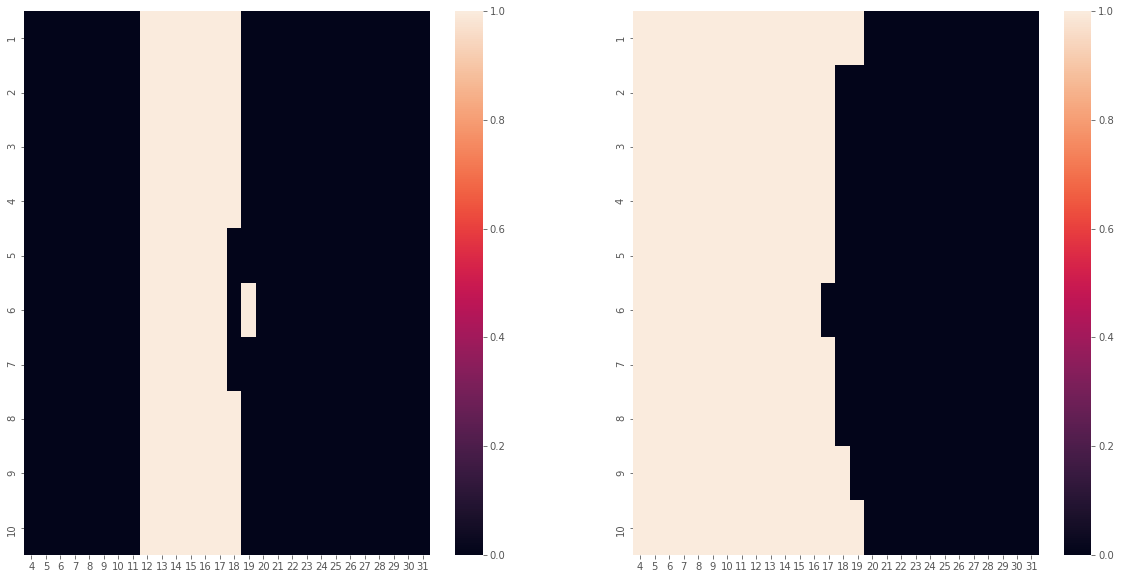

In [0]:
plot_policy(Q, optim_policy)

# 7. Backward-view SARSA($\lambda$)



Just like TD($\lambda$), we also have a backward view algorithm that uses*Eligibility traces* in the online algorithm

- SARSA($\lambda$) has one eligibility trace for each state-action pair
 
 \begin{equation}
 \begin{split}
 E_0(s,a) &= 0 \\
 E_t(s,a) &= \gamma \lambda E_{t-1}(s,a) + \mathop{\mathbb{1}}(S_t=s, A_t=a)
 \end{split}
 \end{equation}
 
- Hence, Q(s,a) is updated for every state $s$ and action $a$ in proportion to TD-error $\delta_t$ and eligibility trace *E_t(s,a)*

 \begin{equation}
 \begin{split}
 &\delta_t = R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t) \\
 &Q(s,a) \leftarrow Q(s,a) + \alpha \delta_t E_t(s,a)
 \end{split}
 \end{equation}

## Pseudo Code of SARSA($\lambda$) algorithm
---
 ```
 Initialise Q(s,a) arbitrarily, for all s in S, a in A(s)
 Loop for each episode:
    E(s,a) = 0 for all s in S, a in A(s)
    Initialise S, A
    
    Loop for each step of the episode:
        Take action At, observe Rt+1, St+1
        Choose At+1 from St+1 using policy derived from Q (e.g. epsilon-greedy)
        delta = R + gamma * Q(St+1, At+1) - Q(S,A)
        E(S,A) = E(S,A) + 1      # Update The Eligibility Trace
        
        For all s in S, a in A(s):
            Q(s,a) = Q(s,a) + alpha * delta * E(s,a)
            E(s,a) = gamma * lambda * E(s,a)
            
    Until S is terminal
 ```
---

In [0]:
def backward_sarsa_lambda(env, num_episodes,
                          alpha=0.01, esp=0.3, gamma=1.0, lmd=0.3):
    """
    Backward SARSA Lambda
    """
    
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    eligibility_trace = defaultdict(lambda: np.zeros(env.action_space.n))
    
    policy = epsilon_greedy_policy
    
    for i in range(num_episodes):
        
        if i % 100000 == 0:
            print("Completed %s iterations." % (i))
    
        state = env.reset()

        while True:

            # Select an action given by pi for S
            action = policy(Q[state], env, esp=esp)

            # Take action A, observe R, ns
            next_state, reward, done, info = env.step(action)

            # Select next action given by pi for S
            next_action = policy(Q[next_state], env, esp=esp)

            # Delta
            delta = reward + gamma * Q[next_state][next_action] - Q[state][action]

            # Update eligibility trace
            eligibility_trace[state][action] += 1

            for k in Q:
                Q[k] = Q[k] + alpha * delta * eligibility_trace[k]
                eligibility_trace[k] = gamma * lmd * eligibility_trace[k]

            if done:
                break

            state = next_state

    return Q

In [0]:
%%time
Q = backward_sarsa_lambda(env, num_episodes=500000, esp=0.3, lmd=0)

Completed 0 iterations.
Completed 100000 iterations.
Completed 200000 iterations.
Completed 300000 iterations.
Completed 400000 iterations.
CPU times: user 16min 56s, sys: 801 ms, total: 16min 57s
Wall time: 16min 56s


In [0]:
optim_policy = q_to_policy(Q)

[[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0

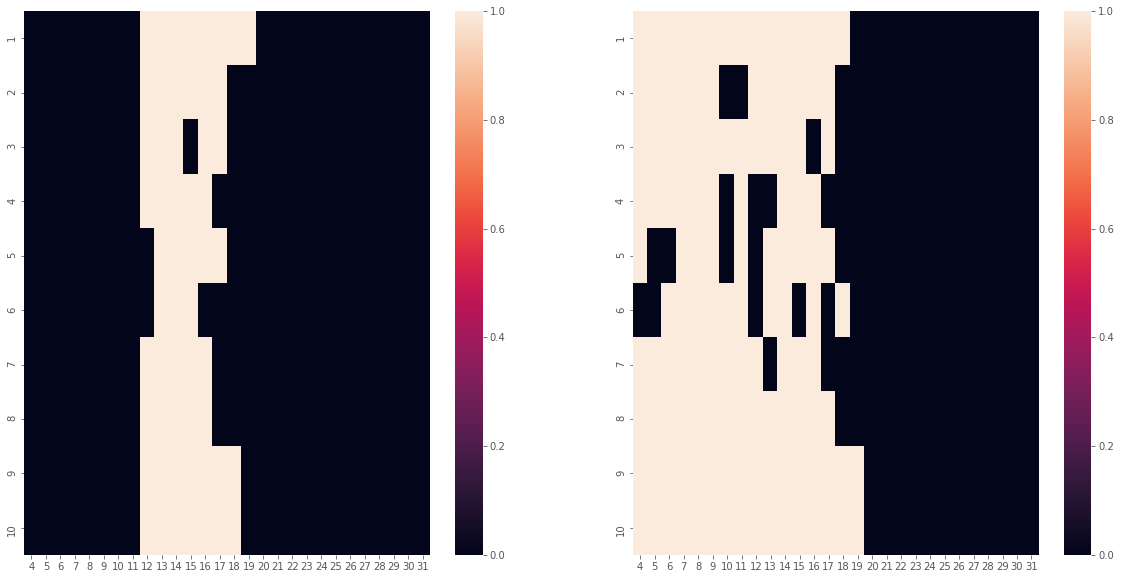

In [0]:
plot_policy(Q, optim_policy)

# 8. Q-learning

#### SARSAMAX update
\begin{equation}
Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t+1} + \gamma \max_{a'}  Q(S_{t+1}, a') - Q(S_t, A_t)]
\end{equation}

##### Pseudo code
---
```
Algorithm parameters: step size alpha, smal epsilon > 0
Initialise Q(s,a) for all s in S+, a in A(s)
Arbitrarily except that Q(terminal,.) = 0

Loop for each episode:
    Initialise S
    Loop for each step of episode:
        Choose A from S using policy derived from Q (e.g. epsilon-greedy)
        Take action A, observe R, S'
        Q(S,A) = Q(S,A) + alpha * (R + gamma * max_aQ(S',a) - Q(S,A))
        S = S'
    until S is terminal
    
```
---

In [0]:
def q_learning(env, num_episodes, alpha=0.1, gamma=1.0, eps=1e-3):
    """
    Q-learning algorithm
    """
    
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for i in range(num_episodes):
        
        state = env.reset()
        
        while True:
            
            action = epsilon_greedy_policy(Q[state], env, eps=eps)
            
            # Take action A, observe R, ns
            next_state, reward, done, info = env.step(action)
            
            # Select next action by greedy policy
            next_action = np.argmax(Q[next_state])
            
            # Update Q
            Q[state][action] += alpha * ((reward + gamma * next_action) - Q[state][action])
            
            if done:
                break
            
            # Update state
            state = next_state
            
    return Q

In [0]:
%%time
Q = q_learning(env, num_episodes=500000, alpha=0.1, eps=0.3)

CPU times: user 24.9 s, sys: 90.2 ms, total: 25 s
Wall time: 24.9 s


In [0]:
optim_policy = q_to_policy(Q)

[[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]]
[[1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

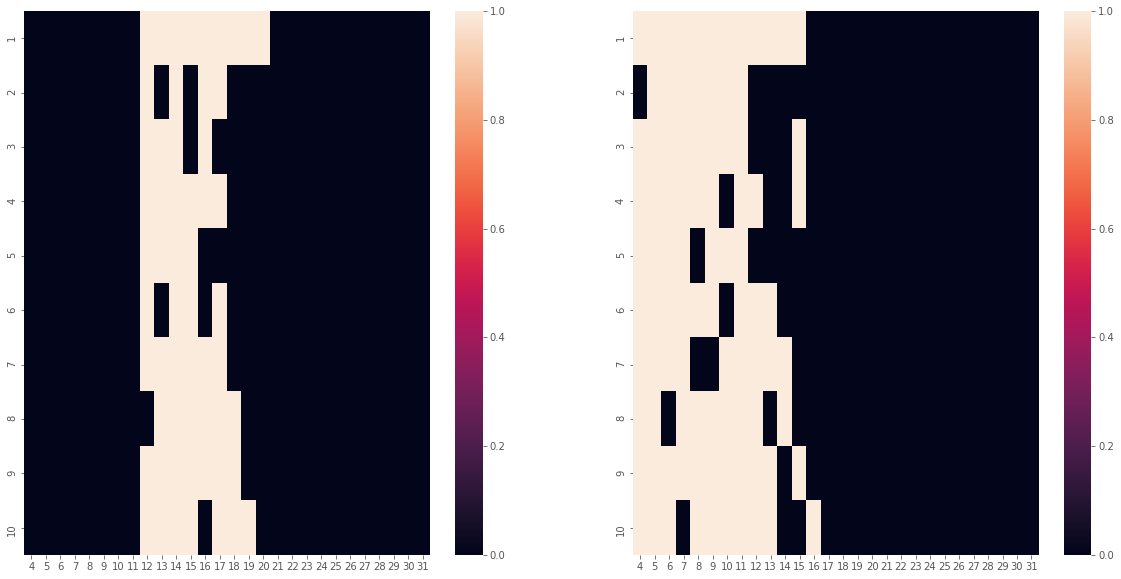

In [0]:
plot_policy(Q, optim_policy)